In [12]:

import keras
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
from keras.applications import NASNetMobile
#from keras.applications.nasnet import preprocess_input

In [3]:
# import images as numpy array = X
X = np.load('X_color.npy', allow_pickle=False)
# import labels as numpy vector = y
y = np.load('y_color.npy', allow_pickle=False)
# oak = 0; maple = 1

403
1


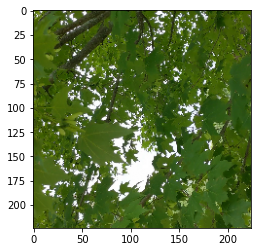

In [4]:
i = int(0.21*X.shape[0])
print(i)
print(y[i])
plt.imshow(X[i])
plt.show()

1478
0


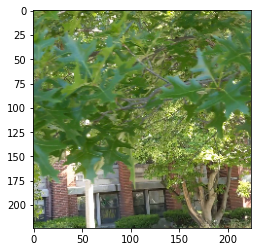

In [5]:
i = int(0.77*X.shape[0])
print(i)
print(y[i])
plt.imshow(X[i])
plt.show()

In [6]:
X = X.reshape((-1,224,224,3))
y = y.reshape((-1,1))
X.shape, y.shape

((1920, 224, 224, 3), (1920, 1))

In [7]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                           y_interim,
                                           test_size=0.4,
                                           random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (921, 224, 224, 3)
921 train samples
615 test samples
384 eval samples


In [28]:
pre_model = NASNetMobile(input_shape=(224,224,3), include_top=False, 
             weights='imagenet', input_tensor=None, pooling='avg')
pre_model.trainable = False

In [14]:
input_shape = x_train.shape[1:]

In [29]:
# set model constants
num_classes = 1
# define model as Sequential
model = Sequential()
model.add(pre_model)
# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))
# show model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 1056)              4269716   
_________________________________________________________________
preds (Dense)                (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 1,057
Non-trainable params: 4,269,716
_________________________________________________________________


In [30]:
model.compile(
    # set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

In [ ]:
# model = keras.models.Sequential()
# model.add(model)
# model.add(keras.layers.Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [35]:
model.fit(
    x_train[:920],
    y_train[:920],
    batch_size=20,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/20
46/46 [==============================] - 101s 2s/step - loss: 0.4218 - accuracy: 0.8543 - val_loss: 0.4351 - val_accuracy: 0.8407
Epoch 2/20
46/46 [==============================] - 97s 2s/step - loss: 0.4116 - accuracy: 0.8554 - val_loss: 0.4248 - val_accuracy: 0.8439
Epoch 3/20
46/46 [==============================] - 96s 2s/step - loss: 0.4031 - accuracy: 0.8587 - val_loss: 0.4166 - val_accuracy: 0.8455
Epoch 4/20
46/46 [==============================] - 97s 2s/step - loss: 0.3945 - accuracy: 0.8663 - val_loss: 0.4111 - val_accuracy: 0.8504
Epoch 5/20
46/46 [==============================] - 97s 2s/step - loss: 0.3872 - accuracy: 0.8641 - val_loss: 0.4030 - val_accuracy: 0.8472
Epoch 6/20
46/46 [==============================] - 96s 2s/step - loss: 0.3803 - accuracy: 0.8707 - val_loss: 0.3960 - val_accuracy: 0.8553
Epoch 7/20
46/46 [==============================] - 96s 2s/step - loss: 0.3739 - accuracy: 0.8717 - val_loss: 0.3897 - val_accuracy: 0.8569
Epoch 8/20
46/46 [=

In [36]:
# test model on evaluation set
model.evaluate(x_eval, y_eval, verbose=2)

12/12 - 16s - loss: 0.3340 - accuracy: 0.8750


[0.3339758813381195, 0.875]

In [33]:
import h5py

In [37]:
# json_model = model.to_json()#save the model architecture to JSON file
# with open('model_arch.json', 'w') as json_file:
#     json_file.write(json_model)#saving the weights of the model
# model.save_weights('model_weights.h5')